# Resampled Importance Sampling Test

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import math
import numpy as np

C:\Users\SHOCKE~1\AppData\Local\Temp/ipykernel_15056/1355671903.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


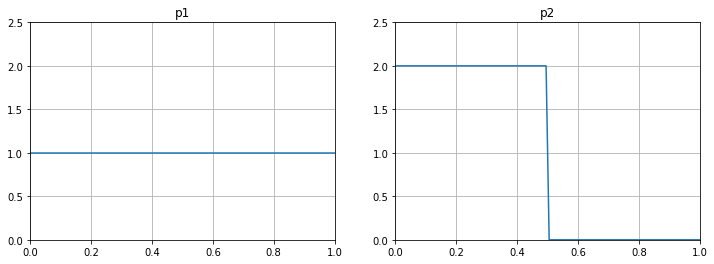

In [2]:
def target_density(xs):
    return 2 - 2 * xs

def sample_p1(us):
    return us

def p1(xs):
    return np.full(xs.shape, 1)

def sample_p2(us):
    return 0.5 * us

def p2(xs):
    return np.where(xs < 0.5, 2, 0)

def sampleRIS(us, ucs, numCandidatesPerSample):
    xs = []
    biased_ws = []
    naive_ws = []
    mis_ws = []
    for sampleIdx in range(len(us)):
        cand_xs = []
        cand_ws = []
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                x = sample_p1(us[sampleIdx][candIdx])
                w = target_density(x) / p1(x)
            else:
                x = sample_p2(us[sampleIdx][candIdx])
                w = target_density(x) / p2(x)
            cand_xs.append(x)
            cand_ws.append(w)
        sum_w = sum(cand_ws)
        uc = sum_w * ucs[sampleIdx]
        selectedIdx = 0
        cum_w = 0
        for candIdx in range(numCandidatesPerSample):
            cum_w += cand_ws[candIdx]
            if cum_w >= uc:
                break
            selectedIdx += 1
        x = cand_xs[selectedIdx]
        xs.append(x)

        biased_ws.append(sum_w / numCandidatesPerSample / target_density(x))

        numNonZeroCandidates = 0
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                p = p1(x)
            else:
                p = p2(x)
            if p > 0.0:
                numNonZeroCandidates += 1
        naive_ws.append(sum_w / numNonZeroCandidates / target_density(x))

        recMisWeight = 0
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                p = p1(x)
            else:
                p = p2(x)
            recMisWeight += p
        use_p1 = candIdx < numCandidatesPerSample // 2
        misWeight = p1(x) if use_p1 else p2(x) / recMisWeight
        mis_ws.append(sum_w * misWeight / target_density(x))
    
    return np.array(xs), np.array(biased_ws), np.array(naive_ws), np.array(mis_ws)

xs = np.linspace(0, 1, 100)
p1s = p1(xs)
p2s = p2(xs)

figure = plt.figure(figsize=(12, 4))
fig_p1 = figure.add_subplot(1, 2, 1)
fig_p1.title.set_text('p1')
fig_p1.set_xlim(0, 1)
fig_p1.set_ylim(0, 2.5)
fig_p1.grid(True)
fig_p1.plot(xs, p1s)
fig_p2 = figure.add_subplot(1, 2, 2)
fig_p2.title.set_text('p2')
fig_p2.set_xlim(0, 1)
fig_p2.set_ylim(0, 2.5)
fig_p2.grid(True)
fig_p2.plot(xs, p2s)
figure.show()

C:\Users\SHOCKE~1\AppData\Local\Temp/ipykernel_15056/3711269038.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


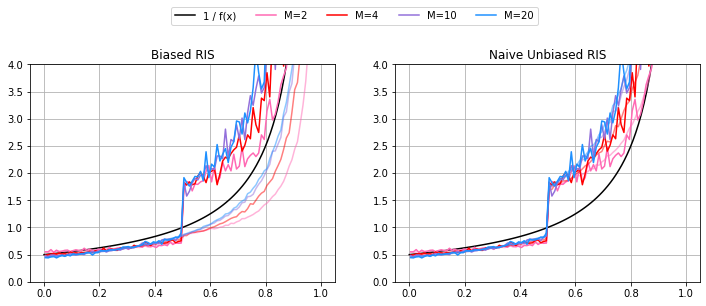

In [3]:
figure = plt.figure(figsize=(12, 4))
figBiased = figure.add_subplot(1, 2, 1)
figBiased.title.set_text('Biased RIS')
figBiased.set_ylim(0, 4)
figBiased.grid(True)
figNaive = figure.add_subplot(1, 2, 2)
figNaive.title.set_text('Naive Unbiased RIS')
figNaive.set_ylim(0, 4)
figNaive.grid(True)

analytic_xs = np.linspace(0, 0.999, 100)
analytic_ys = target_density(analytic_xs)
figBiased.plot(analytic_xs, 1 / analytic_ys, label='1 / f(x)', color='k')
figNaive.plot(analytic_xs, 1 / analytic_ys, label='1 / f(x)', color='k')

numSamples = 50000
numBins = 100
configs = ((2, 'hotpink'), (4, 'red'), (10, 'mediumpurple'), (20, 'dodgerblue'))
for M, plotColor in configs:
    us = []
    ucs = []
    for i in range(numSamples):
        us.append(np.random.rand(M))
        ucs.append(np.random.rand())
    ris_xs, ris_biased_ws, ris_naive_ws, _ = sampleRIS(us, ucs, M)

    hist, histBounds = np.histogram(ris_xs, bins=numBins, range=(0, 1), density=True)
    invHist = np.divide(1.0, hist, out=np.zeros_like(hist), where=hist != 0)
    hist_xs = []
    for i in range(0, len(hist)):
        hist_xs.append((histBounds[i] + histBounds[i + 1]) * 0.5)

    avg_biased_ws = np.zeros(numBins)
    numSamplesPerBin = np.zeros(numBins)
    for i in range(numSamples):
        binIdx = int(min(numBins * ris_xs[i], numBins - 1))
        avg_biased_ws[binIdx] += ris_biased_ws[i]
        numSamplesPerBin[binIdx] += 1
    for i in range(numBins):
        if numSamplesPerBin[i] == 0:
            continue;
        avg_biased_ws[i] /= numSamplesPerBin[i]
    figBiased.plot(hist_xs, avg_biased_ws, color=plotColor, alpha=0.5)
    figBiased.plot(hist_xs, invHist, label='M=' + str(M), color=plotColor)

    avg_naive_ws = np.zeros(numBins)
    numSamplesPerBin = np.zeros(numBins)
    for i in range(numSamples):
        binIdx = int(min(numBins * ris_xs[i], numBins - 1))
        avg_naive_ws[binIdx] += ris_naive_ws[i]
        numSamplesPerBin[binIdx] += 1
    for i in range(numBins):
        if numSamplesPerBin[i] == 0:
            continue;
        avg_naive_ws[i] /= numSamplesPerBin[i]
    figNaive.plot(hist_xs, avg_naive_ws, color=plotColor, alpha=0.5)
    figNaive.plot(hist_xs, invHist, label='M=' + str(M), color=plotColor)

handles, labels = figBiased.get_legend_handles_labels()
figure.legend(handles, labels, ncol=len(configs) + 1, bbox_to_anchor=(0.5, 1.0), loc='lower center')
figure.show()

C:\Users\SHOCKE~1\AppData\Local\Temp/ipykernel_15056/3625868375.py:97: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


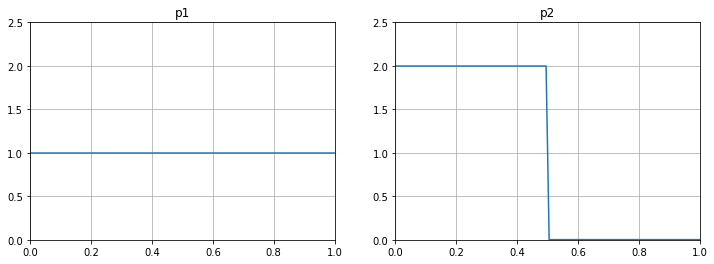

In [4]:
def target_density(xs):
    return 2 - 2 * xs

def sample_p1(us):
    return us

def p1(xs):
    return np.full(xs.shape, 1)

def sample_p2(us):
    isRegion0 = us < 0.999
    if isRegion0:
        t = us / 0.999
        x = 0.5 * t
    else:
        t = (us - 0.999) / 0.001
        x = 0.5 + 0.5 * t
    return x

def p2(xs):
    return np.where(xs < 0.5, 1.998, 0.002)

def sampleRIS(us, ucs, numCandidatesPerSample):
    xs = []
    biased_ws = []
    naive_ws = []
    mis_ws = []
    for sampleIdx in range(len(us)):
        cand_xs = []
        cand_ws = []
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                x = sample_p1(us[sampleIdx][candIdx])
                w = target_density(x) / p1(x)
            else:
                x = sample_p2(us[sampleIdx][candIdx])
                w = target_density(x) / p2(x)
            cand_xs.append(x)
            cand_ws.append(w)
        sum_w = sum(cand_ws)
        uc = sum_w * ucs[sampleIdx]
        selectedIdx = 0
        cum_w = 0
        for candIdx in range(numCandidatesPerSample):
            cum_w += cand_ws[candIdx]
            if cum_w >= uc:
                break
            selectedIdx += 1
        x = cand_xs[selectedIdx]
        xs.append(x)

        biased_ws.append(sum_w / numCandidatesPerSample / target_density(x))

        numNonZeroCandidates = 0
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                p = p1(x)
            else:
                p = p2(x)
            if p > 0.0:
                numNonZeroCandidates += 1
        naive_ws.append(sum_w / numNonZeroCandidates / target_density(x))

        recMisWeight = 0
        for candIdx in range(numCandidatesPerSample):
            use_p1 = candIdx < numCandidatesPerSample // 2
            if use_p1:
                p = p1(x)
            else:
                p = p2(x)
            recMisWeight += p
        use_p1 = selectedIdx < numCandidatesPerSample // 2
        misWeight = (p1(x) if use_p1 else p2(x)) / recMisWeight
        mis_ws.append(sum_w * misWeight / target_density(x))
    
    return np.array(xs), np.array(biased_ws), np.array(naive_ws), np.array(mis_ws)

xs = np.linspace(0, 1, 100)
p1s = p1(xs)
p2s = p2(xs)

figure = plt.figure(figsize=(12, 4))
fig_p1 = figure.add_subplot(1, 2, 1)
fig_p1.title.set_text('p1')
fig_p1.set_xlim(0, 1)
fig_p1.set_ylim(0, 2.5)
fig_p1.grid(True)
fig_p1.plot(xs, p1s)
fig_p2 = figure.add_subplot(1, 2, 2)
fig_p2.title.set_text('p2')
fig_p2.set_xlim(0, 1)
fig_p2.set_ylim(0, 2.5)
fig_p2.grid(True)
fig_p2.plot(xs, p2s)
figure.show()

C:\Users\SHOCKE~1\AppData\Local\Temp/ipykernel_15056/2115653822.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


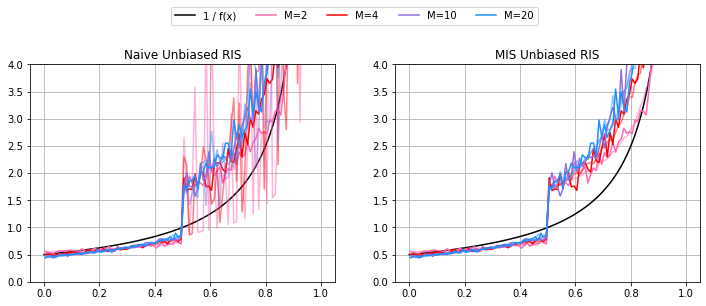

In [5]:
figure = plt.figure(figsize=(12, 4))
figNaive = figure.add_subplot(1, 2, 1)
figNaive.title.set_text('Naive Unbiased RIS')
figNaive.set_ylim(0, 4)
figNaive.grid(True)
figMIS = figure.add_subplot(1, 2, 2)
figMIS.title.set_text('MIS Unbiased RIS')
figMIS.set_ylim(0, 4)
figMIS.grid(True)

analytic_xs = np.linspace(0, 0.999, 100)
analytic_ys = target_density(analytic_xs)
figNaive.plot(analytic_xs, 1 / analytic_ys, label='1 / f(x)', color='k')
figMIS.plot(analytic_xs, 1 / analytic_ys, label='1 / f(x)', color='k')

numSamples = 50000
numBins = 100
configs = ((2, 'hotpink'), (4, 'red'), (10, 'mediumpurple'), (20, 'dodgerblue'))
for M, plotColor in configs:
    us = []
    ucs = []
    for i in range(numSamples):
        us.append(np.random.rand(M))
        ucs.append(np.random.rand())
    ris_xs, _, ris_naive_ws, ris_mis_ws = sampleRIS(us, ucs, M)

    hist, histBounds = np.histogram(ris_xs, bins=numBins, range=(0, 1), density=True)
    invHist = np.divide(1.0, hist, out=np.zeros_like(hist), where=hist != 0)
    hist_xs = []
    for i in range(0, len(hist)):
        hist_xs.append((histBounds[i] + histBounds[i + 1]) * 0.5)

    avg_naive_ws = np.zeros(numBins)
    numSamplesPerBin = np.zeros(numBins)
    for i in range(numSamples):
        binIdx = int(min(numBins * ris_xs[i], numBins - 1))
        avg_naive_ws[binIdx] += ris_naive_ws[i]
        numSamplesPerBin[binIdx] += 1
    for i in range(numBins):
        if numSamplesPerBin[i] == 0:
            continue;
        avg_naive_ws[i] /= numSamplesPerBin[i]
    figNaive.plot(hist_xs, avg_naive_ws, color=plotColor, alpha=0.5)
    figNaive.plot(hist_xs, invHist, label='M=' + str(M), color=plotColor)

    avg_mis_ws = np.zeros(numBins)
    numSamplesPerBin = np.zeros(numBins)
    for i in range(numSamples):
        binIdx = int(min(numBins * ris_xs[i], numBins - 1))
        avg_mis_ws[binIdx] += ris_mis_ws[i]
        numSamplesPerBin[binIdx] += 1
    for i in range(numBins):
        if numSamplesPerBin[i] == 0:
            continue;
        avg_mis_ws[i] /= numSamplesPerBin[i]
    figMIS.plot(hist_xs, avg_mis_ws, color=plotColor, alpha=0.5)
    figMIS.plot(hist_xs, invHist, label='M=' + str(M), color=plotColor)

handles, labels = figMIS.get_legend_handles_labels()
figure.legend(handles, labels, ncol=len(configs) + 1, bbox_to_anchor=(0.5, 1.0), loc='lower center')
figure.show()

RISウェイトとは W(x, z) のこと。
- Biased RIS
  - 現在のピクセルでターゲット関数(!=被積分関数)が値を持つ箇所で、candidate PDFがゼロだとBiasedになる。
- Unbiased RIS
  - RISウェイトのmが同じサンプル、異なる戦略に対して合計1になるならunbiasedとなる。

### 4.4
ピクセル q は隣接ピクセルからレゼボア r_i を集める。それぞれサンプル r_i.y を持っている。しかしこのサンプルのPDFは q における被積分関数が値を持つところでゼロになっている可能性がある。例えば、半球の下側にまわってしまう候補は通常破棄されるが、隣接するピクセルは異なる傾きの面法線をもっているかもしれないため、 q において非ゼロの寄与を持つサンプルが破棄されてしまうかもしれない。同様に、我々のアルゴリズムはリサンプリングの第一段階の後、遮蔽されているサンプルを破棄します(実質的にPDFをゼロにセットする)。しかしあるピクセルにおいて遮蔽されているサンプルが隣接するピクセルでそうでない可能性があり、破棄によってバイアスが生じてしまう。

Visibility Reuseを使っている場合